RANDOM FOREST REGRESSOR MODEL


Model Evaluation:
  RMSE: 0.8660
  R² Score: 0.8242

Feature Importances:
     Feature  Importance
5      Month    0.234959
1       TMAX    0.197796
8  is_winter    0.183304
0       TAVG    0.130909
3       PRCP    0.097260
2       TMIN    0.070599
7  is_summer    0.054563
6        Day    0.028640
4       SNOW    0.001970


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


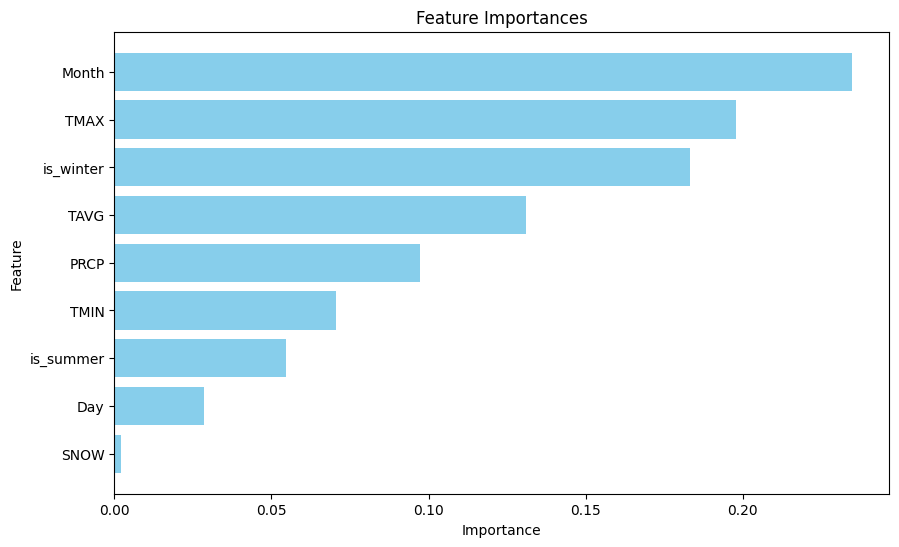

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load and Clean the Dataset
file_path = r'/Users/sushma/Documents/BigData/bd_project/Big_Data_Project/kafka_project/data/merged_cleaned_data.csv'

data = pd.read_csv(file_path)
data.replace(-999, pd.NA, inplace=True)
data_cleaned = data.dropna().copy()  

# Feature Engineering
data_cleaned['DATE'] = pd.to_datetime(data_cleaned['DATE'])  # Convert 'DATE' column to datetime
data_cleaned['Month'] = data_cleaned['DATE'].dt.month       # Extract month
data_cleaned['Day'] = data_cleaned['DATE'].dt.day           # Extract day
data_cleaned['is_summer'] = data_cleaned['Month'].apply(lambda x: 1 if x in [6, 7, 8] else 0)
data_cleaned['is_winter'] = data_cleaned['Month'].apply(lambda x: 1 if x in [12, 1, 2] else 0)

# Define Features and Target
features = ['TAVG', 'TMAX', 'TMIN', 'PRCP', 'SNOW', 'Month', 'Day', 'is_summer', 'is_winter']
target = 'ALLSKY_SFC_SW_DWN'

X = data_cleaned[features]
y = data_cleaned[target]

#  Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest Model
rf_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=20,
    max_features='sqrt',
    min_samples_split=10,
    min_samples_leaf=2,
    random_state=100
)
rf_model.fit(X_train, y_train)

# Predictions and Evaluation
y_test_pred = rf_model.predict(X_test)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
test_r2 = r2_score(y_test, y_test_pred)

print("\nModel Evaluation:")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  R² Score: {test_r2:.4f}")

# Feature Importance
feature_importances = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances)

plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.show()


PREDICTING SOLAR RADIATION AND ENERGY GENERATED BY TAKING USER INPUTS

In [6]:
def predict_solar_energy_with_location(model, data):

    # # Get unique cities from the dataset
    # cities = data['CITY_x'].unique()

    # Define the input features
    feature_names = ['TAVG', 'TMAX', 'TMIN', 'PRCP', 'SNOW', 'Month', 'Day', 'is_summer', 'is_winter']
    
    print("Enter the following features:")
    input_features = []

    # Loop through other features
    for feature in feature_names[:-2]:  
        value = float(input(f"{feature}: "))
        input_features.append(value)

    # Add seasonal flags based on the input month
    month = int(input_features[5])  
    is_summer = 1 if month in [6, 7, 8] else 0
    is_winter = 1 if month in [12, 1, 2] else 0

    # Append seasonal flags to the feature set
    input_features.append(is_summer)
    input_features.append(is_winter)

    # Add solar panel efficiency
    efficiency = float(input("\nEnter the solar panel efficiency (e.g., 0.18 for 18%): "))
    
    # Create a DataFrame for prediction
    input_df = pd.DataFrame([input_features], columns=feature_names)
    
    # Predict solar radiation
    predicted_radiation = model.predict(input_df)[0]
    
    # Calculate energy output
    area_sq_km = 1  # Assume 1 square kilometer
    area_sq_m = area_sq_km * 1e6  # Convert to square meters
    solar_energy = predicted_radiation * area_sq_m * efficiency

    # Display results
    print(f"\nPredicted Solar Radiation (ALLSKY_SFC_SW_DWN) : {predicted_radiation:.2f} kWh/m²/day")
    print(f"Predicted Solar Energy Output: {solar_energy:.2f} kWh/day")

    return predicted_radiation, solar_energy



#  Prediction Function
predict_solar_energy_with_location(rf_model, data_cleaned)


Enter the following features:


TAVG:  25
TMAX:  30
TMIN:  20
PRCP:  0
SNOW:  0
Month:  7
Day:  4

Enter the solar panel efficiency (e.g., 0.18 for 18%):  0.16



Predicted Solar Radiation (ALLSKY_SFC_SW_DWN) : 6.71 kWh/m²/day
Predicted Solar Energy Output: 1074128.41 kWh/day


(np.float64(6.713302535692306), np.float64(1074128.4057107691))

MACHINE UNLEARNING (REMOVING BAKERSFEILD DATA)

In [9]:
# Machine Unlearning - Remove Rows Related to Bakersfield
rows_to_remove = data_cleaned[data_cleaned['CITY_x'] == 'Bakersfield']
data_unlearned = data_cleaned.drop(rows_to_remove.index)

# Define Features and Target for the Updated Dataset
X_unlearned = data_unlearned[features]
y_unlearned = data_unlearned[target]

# Train-Test Split After Unlearning
X_train_unlearned, X_test_unlearned, y_train_unlearned, y_test_unlearned = train_test_split(
    X_unlearned, y_unlearned, test_size=0.2, random_state=42
)

# Retrain the Model with the Updated Data
rf_model_unlearned = RandomForestRegressor(
    n_estimators=500,
    max_depth=20,
    max_features='sqrt',
    min_samples_split=10,
    min_samples_leaf=2,
    random_state=100
)
rf_model_unlearned.fit(X_train_unlearned, y_train_unlearned)

# Evaluate the Updated Model
y_test_pred_unlearned = rf_model_unlearned.predict(X_test_unlearned)
test_rmse_unlearned = mean_squared_error(y_test_unlearned, y_test_pred_unlearned, squared=False)
test_r2_unlearned = r2_score(y_test_unlearned, y_test_pred_unlearned)

print("\nUpdated Model Evaluation After Unlearning Bakersfield Data:")
print(f"  RMSE: {test_rmse_unlearned:.4f}")
print(f"  R² Score: {test_r2_unlearned:.4f}")

# Prediction Function with Updated Model
def predict_solar_energy_with_location(model, data):

    # Define the input features
    feature_names = ['TAVG', 'TMAX', 'TMIN', 'PRCP', 'SNOW', 'Month', 'Day', 'is_summer', 'is_winter']
    
    print("Enter the following features:")
    input_features = []

    # Loop through other features
    for feature in feature_names[:-2]:  
        value = float(input(f"{feature}: "))
        input_features.append(value)

    # Add seasonal flags based on the input month
    month = int(input_features[5])  
    is_summer = 1 if month in [6, 7, 8] else 0
    is_winter = 1 if month in [12, 1, 2] else 0

    # Append seasonal flags to the feature set
    input_features.append(is_summer)
    input_features.append(is_winter)

    # Add solar panel efficiency
    efficiency = float(input("\nEnter the solar panel efficiency (e.g., 0.18 for 18%): "))
    
    # Create a DataFrame for prediction
    input_df = pd.DataFrame([input_features], columns=feature_names)
    
    # Predict solar radiation
    predicted_radiation = model.predict(input_df)[0]
    
    # Calculate energy output
    area_sq_km = 1  # Assume 1 square kilometer
    area_sq_m = area_sq_km * 1e6  # Convert to square meters
    solar_energy = predicted_radiation * area_sq_m * efficiency

    # Display results
    print(f"\nPredicted Solar Radiation (ALLSKY_SFC_SW_DWN): {predicted_radiation:.2f} kWh/m²/day")
    print(f"Predicted Solar Energy Output: {solar_energy:.2f} kWh/day")

    return predicted_radiation, solar_energy

# Manual Predictions After Unlearning
predict_solar_energy_with_location(rf_model_unlearned, data_unlearned)


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



Updated Model Evaluation After Unlearning Bakersfield Data:
  RMSE: 0.9047
  R² Score: 0.8018
Enter the following features:


TAVG:  25
TMAX:  30
TMIN:  20
PRCP:  0
SNOW:  0
Month:  7
Day:  4

Enter the solar panel efficiency (e.g., 0.18 for 18%):  0.16



Predicted Solar Radiation (ALLSKY_SFC_SW_DWN): 6.63 kWh/m²/day
Predicted Solar Energy Output: 1061084.67 kWh/day


(np.float64(6.6317792046667075), np.float64(1061084.6727466732))